<a href="https://colab.research.google.com/github/MarcoC1796/recommender-systems-thesis/blob/main/LatentFactorWithMovieDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os, sys, importlib

user = "MarcoC1796"
repo = "recommender-systems-thesis"
src_dir = "src"

if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

path = f"{repo}"
if not path in sys.path:
    sys.path.append(path)

Cloning into 'recommender-systems-thesis'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 245 (delta 94), reused 84 (delta 47), pack-reused 110
Receiving objects: 100% (245/245), 98.06 MiB | 29.61 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Updating files: 100% (28/28), done.


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.LatentFactorsCollabortiveFiltering import LatentFactorsCollaborativeFiltering
from src.aux_functions import standardize_interactions, exclude_unknown_users_items_in_test, reindex_interactions, reindex_interactions_based_on_mapping

plt.style.use("ggplot")

In [15]:
path = "/content/drive/MyDrive/Thesis/Data/"
path += "ml-1m/ratings.dat"

rnames = ["user_id", "movie_id", "rating", "timestamp"]
movies = pd.read_table(path, sep="::", header=None, names=rnames, engine="python")
movies_interactions_array = movies.drop('timestamp', axis=1).values

movies_df_matrix = pd.pivot_table(movies, values="rating", index="user_id", columns="movie_id")

R = movies_df_matrix.to_numpy()
num_users, num_items = R.shape
total_ratings = np.count_nonzero(~np.isnan(R))
total_posible_ratings = R.size
print(f"R is {round((total_ratings/total_posible_ratings)*100, 2)}% full with {total_ratings:,} ratings out of {total_posible_ratings:,} posible ratings, {num_users:,} users, and {num_items:,} items.")

train_val_set, test_set = train_test_split(movies_interactions_array, test_size=1/10, random_state=42)
print(f"Number of interactions in training and validation sets: {train_val_set.shape[0]:,}.")
print(f"Number of interactions in test set: {test_set.shape[0]:,}.")

R is 4.47% full with 1,000,209 ratings out of 22,384,240 posible ratings, 6,040 users, and 3,706 items.
Number of interactions in training and validation sets: 900,188.
Number of interactions in test set: 100,021.


In [16]:
train_set, val_set = train_test_split(train_val_set, test_size=1/9, random_state=42)
num_train_users = len(np.unique(train_set[:,0]))
num_train_items = len(np.unique(train_set[:,1]))
print(f"Number of interactions in training set: {train_set.shape[0]:,} with {num_train_users} users and {num_train_items} items.")
print(f"Number of interactions in validation set: {val_set.shape[0]:,}.")

Number of interactions in training set: 800,167 with 6040 users and 3679 items.
Number of interactions in validation set: 100,021.


In [17]:
filtered_test_set = exclude_unknown_users_items_in_test(train_set, test_set)
filtered_val_set = exclude_unknown_users_items_in_test(train_set, val_set)
print(f"Number of interactions in filtered test set: {filtered_test_set.shape[0]:,}")
print(f"Number of interactions in filtered validation set: {filtered_val_set.shape[0]:,}")

Number of interactions in filtered test set: 100,008
Number of interactions in filtered validation set: 100,006


In [18]:
reindexed_train_set, user_mapping, item_mapping = reindex_interactions(train_set)
reindexed_val_set = reindex_interactions_based_on_mapping(filtered_val_set, user_mapping, item_mapping)
reindexed_test_set = reindex_interactions_based_on_mapping(filtered_test_set, user_mapping, item_mapping)

In [95]:
def get_average_ratings_per_user(interactions):
    users, indices = np.unique(interactions[:, 0], return_inverse=True)
    total_ratings = np.bincount(indices, weights=interactions[:, 2])
    count_ratings = np.bincount(indices)
    return total_ratings / count_ratings

def get_average_ratings_per_item(interactions):
    items, indices = np.unique(interactions[:, 1], return_inverse=True)
    total_ratings = np.bincount(indices, weights=interactions[:, 2])
    count_ratings = np.bincount(indices)
    return total_ratings / count_ratings

def split_interactions(interactions):
        users, items, ratings = np.split(interactions, 3, axis=1)
        users = users.flatten().astype(int)
        items = items.flatten().astype(int)
        ratings = ratings.flatten()
        return users, items, ratings

_, mean_train, std_train = standardize_interactions(reindexed_train_set)

average_ratings_per_user = get_average_ratings_per_user(reindexed_train_set)
average_ratings_per_item = get_average_ratings_per_item(reindexed_train_set)

sample_bias_users = average_ratings_per_user - mean_train
sample_bias_items = average_ratings_per_item - mean_train

def predict(users, items):
  return mean_train + sample_bias_users[users] + sample_bias_items[items]

def get_RMSE(interactions):
  users, items, ratings = split_interactions(interactions)
  predictions =  predict(users, items)
  
  errors = ratings - predictions
  rmse = np.sqrt(np.mean(errors**2))
  return rmse

print(round(get_RMSE(reindexed_val_set),2))

0.93


(6040,)

In [ ]:
num_factors_list = [0,1,2] + list(range(5,101,5))
train_errors_result = []
val_errors_result = []
train_errors_result_bias = []
val_errors_result_bias = []
models = []
models_bias = []

pbar = tqdm(num_factors_list)
for num_factors in pbar:
  pbar.set_description(f"Current Factors: {num_factors} | Progress")
  #model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1], include_biases=False)
  #train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=32, learning_rate=1e-2)
  #train_errors_result.append(train_errors)
  #val_errors_result.append(val_errors)
  #models.append(model)
  model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
  reg = 0
  learning_rate = 1e-2
  if num_factors > 100:
    learning_rate = 1e-3
  train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=512, learning_rate=learning_rate,reg_strength=reg)
  train_errors_result_bias.append(train_errors)
  val_errors_result_bias.append(val_errors)
  models_bias.append(model)

In [ ]:
num_factors_list = np.logspace(base=10,start=-2,stop=-1,num=5)
train_errors_result = []
val_errors_result = []
train_errors_result_bias = []
val_errors_result_bias = []
models = []
models_bias = []

pbar = tqdm(num_factors_list)
for num_factors in pbar:
  pbar.set_description(f"Current Factors: {num_factors} | Progress")
  #model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1], include_biases=False)
  #train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=32, learning_rate=1e-2)
  #train_errors_result.append(train_errors)
  #val_errors_result.append(val_errors)
  #models.append(model)
  model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
  train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=100,validation_interactions=test_set, epochs=8, batch_size=128, learning_rate=1e-2,reg_strength=num_factors)
  train_errors_result_bias.append(train_errors)
  val_errors_result_bias.append(val_errors)
  models_bias.append(model)

In [ ]:
from google.colab import files
import json

data_to_save = {
    "num_factors_list": num_factors_list,
    "train_errors_result_bias": train_errors_result_bias,
    "val_errors_result_bias":val_errors_result_bias
    # Add more data here
}
x = json.dumps (data_to_save)
y = x.encode('utf-8')
with open('example.txt', 'w') as f:
  f.write(str(y))

files.download('example.txt')

In [ ]:
variable_name = f'{num_factors_list=}'.split('=')[0]
print(variable_name)

In [ ]:
models[-1].item_embeddings[:,-5:]

In [ ]:
np.mean((models[-1].user_embeddings @ models[-1].item_embeddings.T))

In [ ]:

# Uncomment the following line to adjust the figure size if needed
# plt.figure(figsize=(8, 6))

biases = True

# Define a list of line styles, markers, and colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'v']
colors = sns.color_palette('husl', len(num_factors_list))

for idx, (num_factors, train_errors, val_errors) in enumerate(zip(num_factors_list, train_errors_result_bias, val_errors_result_bias)):
    list1 = train_errors
    list2 = val_errors
    # Choose a distinct line style, marker, and color for each line
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]
    
    # Plotting the lists with distinct line style, marker, and color
    #plt.plot(list1[-4:], label=f'Training error | factors={num_factors} | biases={biases}', linestyle=line_style, marker=marker, color=color)
    plt.plot(list2[-4:], label=f'Validation error | factors={num_factors} | biases={biases}', linestyle=line_style, marker=marker, color=color)

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.show()

In [ ]:
i = 1
min_train_errors = [min(val_errors) for val_errors in train_errors_result_bias]
min_val_errors= [min(val_errors) for val_errors in val_errors_result_bias]
plt.plot(num_factors_list[:], min_train_errors, label="train")
plt.plot(num_factors_list[:], min_val_errors, label = "val")
plt.legend()
plt.show()
print(num_factors_list[np.argmin(min_val_errors)])

In [ ]:
list1 = train_errors_result_bias[0]
list2= val_errors_result_bias[0]
# Plotting the lists
plt.plot(list1, label='List 1')
plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
(models[1].user_embeddings @ models[1].item_embeddings.T)[~np.isnan(R)].max()

In [ ]:
models[1].item_embeddings[:,2].max()

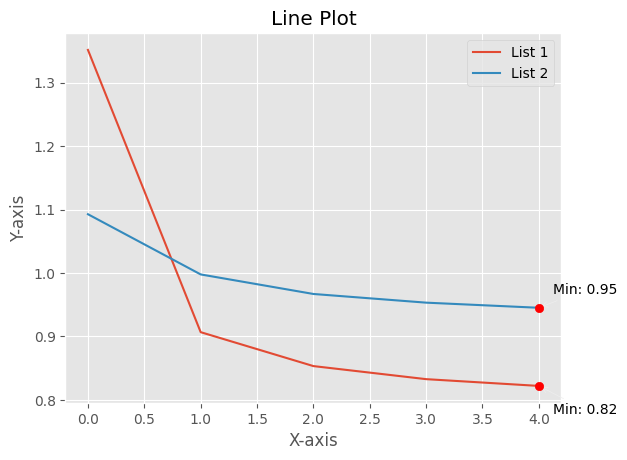

In [ ]:
list1 = train_errors
list2 = val_errors

# Plotting the lists
plt.plot(list1, label='List 1')
plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
from src.aux_functions import standardize_interactions
import inspect
lines = inspect.getsource(LatentFactorsCollaborativeFiltering)
print(lines)

In [ ]:
a = np.array([1, 2, 3, 4])
indices = np.array([0, 1, 0, 1])
values = np.array([10, 20, 30, 40])
np.add.at(a, indices, values)
print(a)

In [ ]:
a = np.array([1, 2, 3, 4])
indices = np.array([0, 1, 0, 1])
values = np.array([10, 20, 30, 40])
a[indices] += values
print(a)

In [ ]:
model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
train_errors, val_errors = model.fit(train_interactions=train_val_set, 
                                     num_factors=10,
                                     epochs=5, 
                                     batch_size=64, 
                                     learning_rate=0.01,
                                     reg_strength=0)

RMSE: None | Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/12503 [00:00<?, ?it/s]

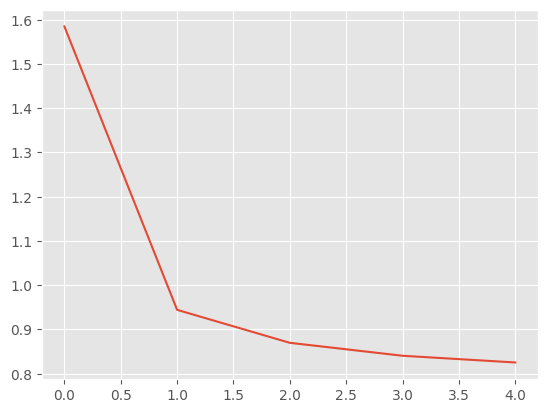

In [ ]:
plt.plot(train_errors)
plt.show()

In [ ]:
train_errors

[1.5932637178424072]

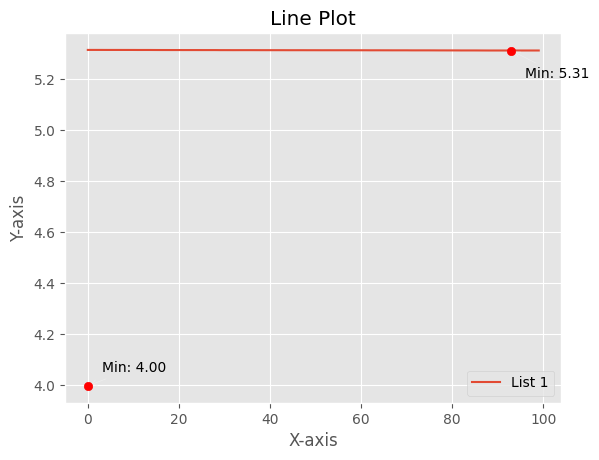

In [ ]:
list1 = train_errors
list2 = val_errors

# Plotting the lists
plt.plot(list1, label='List 1')
#plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [61]:
import numpy as np
from tqdm.auto import trange
from src.aux_functions import standardize_interactions


class LatentFactorsCollaborativeFiltering:
    def __init__(
        self,
        num_users,
        num_items,
        num_factors=10,
        include_biases=True,
        standardize=True,
    ):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.include_biases = include_biases
        self.user_biases = None
        self.item_biases = None
        self.user_embeddings = None
        self.item_embeddings = None
        self.standardize = standardize
        self.mean_train = None
        self.std_train = None
        self.user_ratings_counts = None
        self.item_ratings_counts = None

    def fit(
        self,
        train_interactions,
        validation_interactions=None,
        num_factors=None,
        reg_strength=0,
        epochs=10,
        batch_size=128,
        learning_rate=0.01,
        tolerance=None,
        max_batches_per_epoch=None,
        compute_detailed_errors=False,
    ):
        if num_factors is not None:
            self.num_factors = num_factors

        self.set_ratings_count_per_user_per_item(train_interactions)

        if self.standardize:
            train_interactions, mean_train, std_train = standardize_interactions(
                train_interactions
            )
            self.mean_train = mean_train
            self.std_train = std_train
        else:
            _, mean_train, std_train = standardize_interactions(train_interactions)
            self.mean_train = mean_train
            self.std_train = std_train

        self.initililize_embeddings()

        initial_train_RMSE = self.evaluate_RMSE(train_interactions)
        train_errors = [initial_train_RMSE]

        validation_errors = []
        if validation_interactions is not None:
            initial_validation_RMSE = self.evaluate_RMSE(
                validation_interactions, test=True
            )
            validation_errors.append(initial_validation_RMSE)

        pbar_outer = trange(
            epochs, desc=f"RMSE: {initial_train_RMSE:.2e} | Progress: ", leave=False
        )

        for epoch in pbar_outer:
            np.random.shuffle(train_interactions)

            num_batches = (
                int(np.ceil(len(train_interactions) / batch_size))
                if max_batches_per_epoch is None
                else max_batches_per_epoch
            )

            pbar_inner = trange(
                num_batches, desc=f"Epoch {epoch+1}/{epochs}", leave=False
            )

            for batch_idx in pbar_inner:
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size
                batch_interactions = train_interactions[start_idx:end_idx]

                self.update_params(batch_interactions, learning_rate, reg_strength)

                if compute_detailed_errors:
                    train_RMSE = self.evaluate_RMSE(train_interactions)
                    train_errors.append(train_RMSE)

            if not compute_detailed_errors:
                train_RMSE = self.evaluate_RMSE(train_interactions)
                train_errors.append(train_RMSE)

            if validation_interactions is not None:
                validation_RMSE = self.evaluate_RMSE(validation_interactions, test=True)
                validation_errors.append(validation_RMSE)

            if tolerance is not None and epoch > 0:
                absolute_improvement = np.abs(train_errors[-2] - train_errors[-1])
                if absolute_improvement / train_errors[-2] < tolerance:
                    pbar_outer.set_description(
                        f"Early Stopping at Epoch {epoch+1} due to tolerance reached | RMSE = {train_errors[-1]:.2e}  | Progress"
                    )
                    break

            pbar_outer.set_description(f"RMSE: {train_errors[-1]:.2e} | Progress")

        pbar_outer.close()
        return train_errors, validation_errors

    def predict(self, users, items):
        user_embeddings_batch = self.user_embeddings[users]
        item_embeddings_batch = self.item_embeddings[items]
        return np.sum(user_embeddings_batch * item_embeddings_batch, axis=1)

    def recommend_items(self, user, top_k=5):
        user_embedding = self.user_embeddings[user]
        scores = np.dot(self.item_embeddings, user_embedding)
        top_item_indices = np.argsort(scores)[::-1][:top_k]
        return top_item_indices

    def update_params(self, interactions, learning_rate, reg_strength):
        errors, users, items = self.evaluate_errors(interactions)

        user_gradients = errors[:, np.newaxis] * self.item_embeddings[items]
        item_gradients = errors[:, np.newaxis] * self.user_embeddings[users]

        if reg_strength > 0:
            if self.include_biases:
                user_gradients[:, :-2] -= (
                    reg_strength
                    * self.user_embeddings[users][:, :-2]
                    / self.user_ratings_counts[users][:, np.newaxis]
                )
                item_gradients[:, :-2] -= (
                    reg_strength
                    * self.item_embeddings[items][:, :-2]
                    / self.item_ratings_counts[items][:, np.newaxis]
                )
            else:
                user_gradients -= (
                    reg_strength
                    * self.user_embeddings[users]
                    / self.user_ratings_counts[users][:, np.newaxis]
                )
                item_gradients -= (
                    reg_strength
                    * self.item_embeddings[items]
                    / self.item_ratings_counts[items][:, np.newaxis]
                )

        np.add.at(self.user_embeddings, users, learning_rate * user_gradients)
        np.add.at(self.item_embeddings, items, learning_rate * item_gradients)

        if self.include_biases:
            self.user_embeddings[:, -1] = 1
            self.item_embeddings[:, -2] = 1

    def update_reg_params(self, interactions, learning_rate, reg_strength):
        (
            unique_users,
            user_gradients,
            unique_items,
            item_gradients,
        ) = self.compute_gradients(interactions, reg_strength)
        self.user_embeddings[unique_users] += learning_rate * user_gradients
        self.item_embeddings[unique_items] += learning_rate * item_gradients

        if self.include_biases:
            self.user_embeddings[:, -1] = 1
            self.item_embeddings[:, -2] = 1

    def compute_gradients(self, interactions, reg_strength):
        errors, users, items = self.evaluate_errors(interactions)

        user_gradients = errors[:, np.newaxis] * self.item_embeddings[items]
        item_gradients = errors[:, np.newaxis] * self.user_embeddings[users]

        unique_users, accumulated_user_gradients = self.accumulate_gradients(
            users, user_gradients
        )
        unique_items, accumulated_item_gradients = self.accumulate_gradients(
            items, item_gradients
        )

        accumulated_user_gradients -= reg_strength * self.user_embeddings[unique_users]
        accumulated_item_gradients -= reg_strength * self.item_embeddings[unique_items]

        return (
            unique_users,
            accumulated_user_gradients,
            unique_items,
            accumulated_item_gradients,
        )

    def accumulate_gradients(self, indices, gradients):
        unique_indices, inverse = np.unique(indices, return_inverse=True)
        accumulated_gradients = np.zeros((unique_indices.shape[0], self.num_factors))
        np.add.at(accumulated_gradients, inverse, gradients)
        return unique_indices, accumulated_gradients

    def evaluate_errors(self, interactions, test=False):
        users, items, ratings = self.split_interactions(interactions)
        predictions = self.predict(users, items)
        if test and self.standardize:
            predictions = predictions * self.std_train + self.mean_train
        errors = ratings - predictions
        return errors, users, items

    def evaluate_RMSE(self, interactions, test=False):
        errors, _, _ = self.evaluate_errors(interactions, test=test)
        rmse = np.sqrt(np.mean(errors**2))
        return rmse

    def initililize_embeddings(self):
        self.num_factors = (
            self.num_factors + 2 if self.include_biases else self.num_factors
        )

        loc = 0 if self.standardize else self.mean_train
        scale = 1 if self.standardize else self.std_train

        self.user_embeddings = np.random.default_rng().normal(
            loc=loc, scale=scale, size=(self.num_users, self.num_factors)
        )
        self.item_embeddings = np.random.default_rng().normal(
            loc=loc, scale=scale, size=(self.num_items, self.num_factors)
        )

        if self.include_biases:
            self.user_embeddings[:, -1] = 1
            self.item_embeddings[:, -2] = 1

    def split_interactions(self, interactions):
        users, items, ratings = np.split(interactions, 3, axis=1)
        users = users.flatten().astype(int)
        items = items.flatten().astype(int)
        ratings = ratings.flatten()
        return users, items, ratings

    def set_ratings_count_per_user_per_item(self, interactions):
        user_ratings_counts = self.count_ratings_per_user(interactions)
        item_ratings_counts = self.count_ratings_per_item(interactions)
        self.user_ratings_counts = user_ratings_counts
        self.item_ratings_counts = item_ratings_counts

    def count_ratings_per_user(self, interactions):
        _, user_ratings_counts = np.unique(interactions[:, 0], return_counts=True)
        return user_ratings_counts

    def count_ratings_per_item(self, interactions):
        _, item_ratings_counts = np.unique(interactions[:, 1], return_counts=True)
        return item_ratings_counts



In [62]:
reg_list = [0, 1, 10, 100]
train_errors_result = []
val_errors_result = []
models = []

pbar = tqdm(reg_list)
for reg_strength in pbar:
    pbar.set_description(f"Current Reg: {reg_strength:.2e} | Progress")
    model = LatentFactorsCollaborativeFiltering(num_train_users, num_train_items)
    train_errors, val_errors = model.fit(train_interactions=reindexed_train_set, 
                                        validation_interactions=reindexed_val_set,
                                        num_factors=25,
                                        epochs=20, 
                                        batch_size=2**8, 
                                        learning_rate=1e-2,
                                        reg_strength=reg_strength)
    train_errors_result.append(train_errors)
    val_errors_result.append(val_errors)
    models.append(model)

  0%|          | 0/4 [00:00<?, ?it/s]

RMSE: 5.26e+00 | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/3126 [00:00<?, ?it/s]

RMSE: 5.24e+00 | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/3126 [00:00<?, ?it/s]

RMSE: 5.22e+00 | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/3126 [00:00<?, ?it/s]

RMSE: 5.23e+00 | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/3126 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/3126 [00:00<?, ?it/s]

In [109]:
reg_list = [0]
train_errors_result_2 = []
val_errors_result_2 = []
models_2 = []

pbar = tqdm(reg_list)
for reg_strength in pbar:
    pbar.set_description(f"Current Reg: {reg_strength:.2e} | Progress")
    model = LatentFactorsCollaborativeFiltering(num_train_users, num_train_items)
    train_errors, val_errors = model.fit(train_interactions=reindexed_train_set, 
                                        validation_interactions=reindexed_val_set,
                                        num_factors=0,
                                        epochs=1000, 
                                        batch_size=2**10, 
                                        learning_rate=1e-3,
                                        reg_strength=reg_strength,
                                        tolerance=1e-4
                                        )
    train_errors_result_2.append(train_errors)
    val_errors_result_2.append(val_errors)
    models_2.append(model)

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE: 1.58e+00 | Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 11/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 12/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 13/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 14/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 15/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 16/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 17/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 18/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 19/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 20/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 21/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 22/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 23/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 24/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 25/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 26/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 27/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 28/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 29/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 30/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 31/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 32/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 33/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 34/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 35/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 36/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 37/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 38/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 39/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 40/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 41/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 42/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 43/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 44/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 45/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 46/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 47/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 48/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 49/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 50/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 51/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 52/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 53/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 54/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 55/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 56/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 57/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 58/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 59/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 60/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 61/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 62/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 63/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 64/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 65/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 66/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 67/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 68/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 69/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 70/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 71/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 72/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 73/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 74/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 75/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 76/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 77/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 78/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 79/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 80/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 81/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 82/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 83/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 84/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 85/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 86/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 87/1000:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 88/1000:   0%|          | 0/782 [00:00<?, ?it/s]

In [41]:
train_errors_result.append(train_errors_10)
val_errors_result.append(val_errors_10)

In [120]:
0.001/max(models_2[0].user_ratings_counts)

5.399568034557235e-07

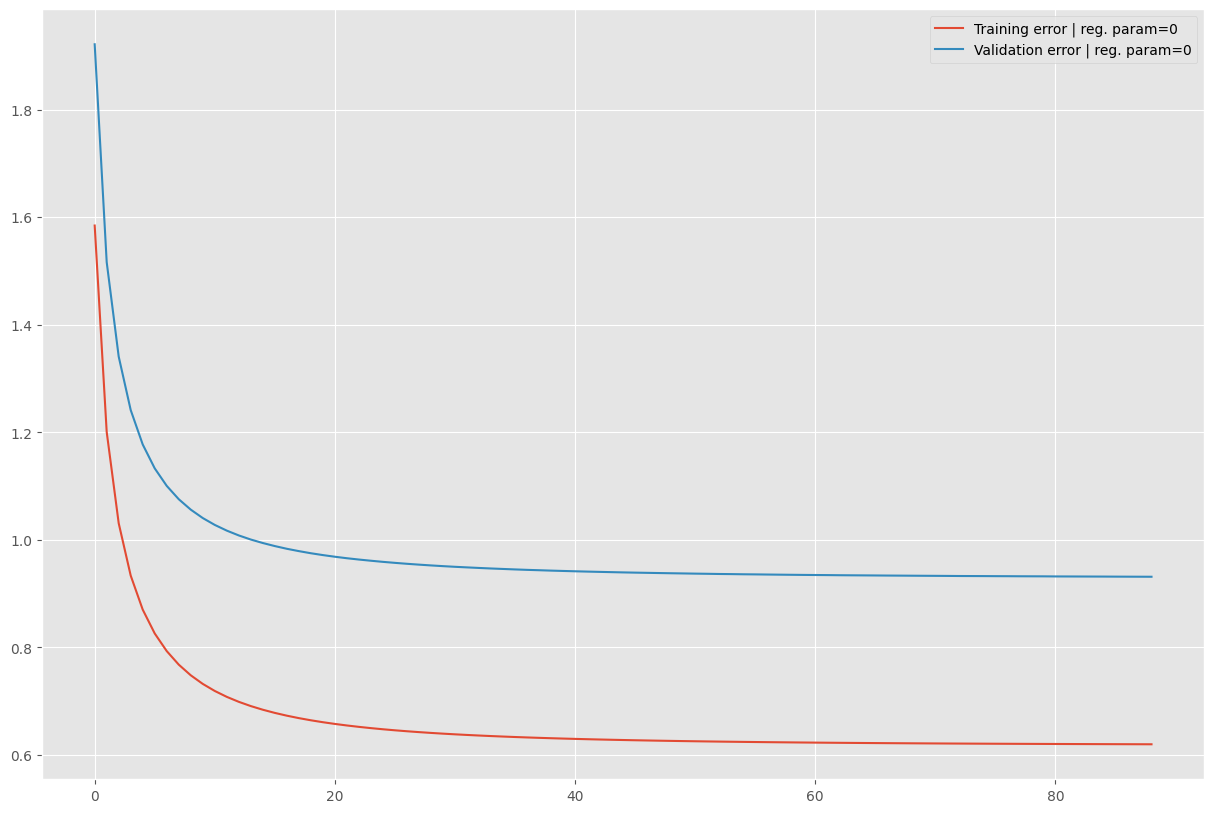

In [111]:
plt.figure(figsize=(15, 10))

biases = True

# Define a list of line styles, markers, and colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'v']
colors = sns.color_palette('husl', len(reg_list))

for idx, (num_factors, train_errors, val_errors) in enumerate(zip(reg_list, train_errors_result_2, val_errors_result_2)):
    list1 = train_errors
    list2 = val_errors
    # Choose a distinct line style, marker, and color for each line
    #line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]
    
    # Plotting the lists with distinct line style, marker, and color
    plt.plot(list1[:], label=f'Training error | reg. param={num_factors}')
    plt.plot(list2[:], label=f'Validation error | reg. param={num_factors}')

# Move the legend outside the plot area
# bbox_to_anchor=(1.02, 0.5), loc='center left'
plt.legend()
plt.show()

In [118]:
min(val_errors_result_2[0])
np.square(0.01)*len(reindexed_train_set)/2

40.00835

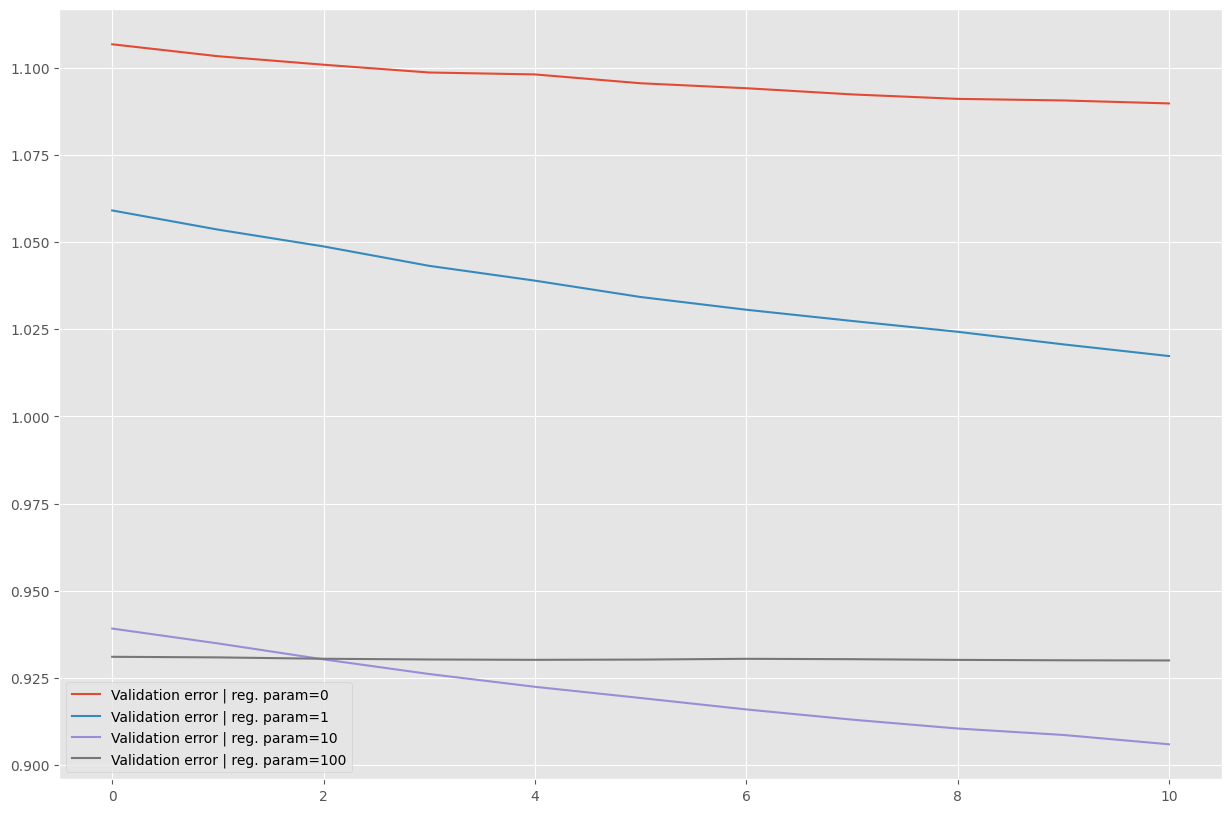

In [86]:
#@title Default title text
plt.figure(figsize=(15, 10))

biases = True

# Define a list of line styles, markers, and colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'v']
colors = sns.color_palette('husl', len(reg_list))

for idx, (num_factors, train_errors, val_errors) in enumerate(zip(reg_list, train_errors_result, val_errors_result)):
    list1 = train_errors
    list2 = val_errors
    # Choose a distinct line style, marker, and color for each line
    #line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]
    
    # Plotting the lists with distinct line style, marker, and color
    #plt.plot(list1[11:], label=f'Training error | reg. param={num_factors}')
    plt.plot(list2[10:], label=f'Validation error | reg. param={num_factors}')

# Move the legend outside the plot area
# bbox_to_anchor=(1.02, 0.5), loc='center left'
plt.legend()
plt.show()

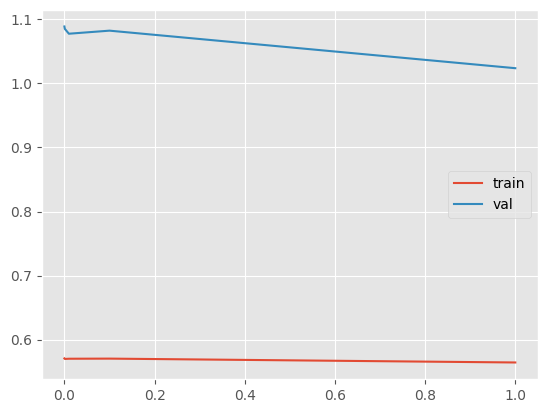

1


In [54]:
i = 1
min_train_errors = [min(val_errors) for val_errors in train_errors_result]
min_val_errors= [min(val_errors) for val_errors in val_errors_result]
plt.plot(reg_list[:], min_train_errors, label="train")
plt.plot(reg_list[:], min_val_errors, label = "val")
plt.legend()
plt.show()
print(reg_list[np.argmin(min_val_errors)])

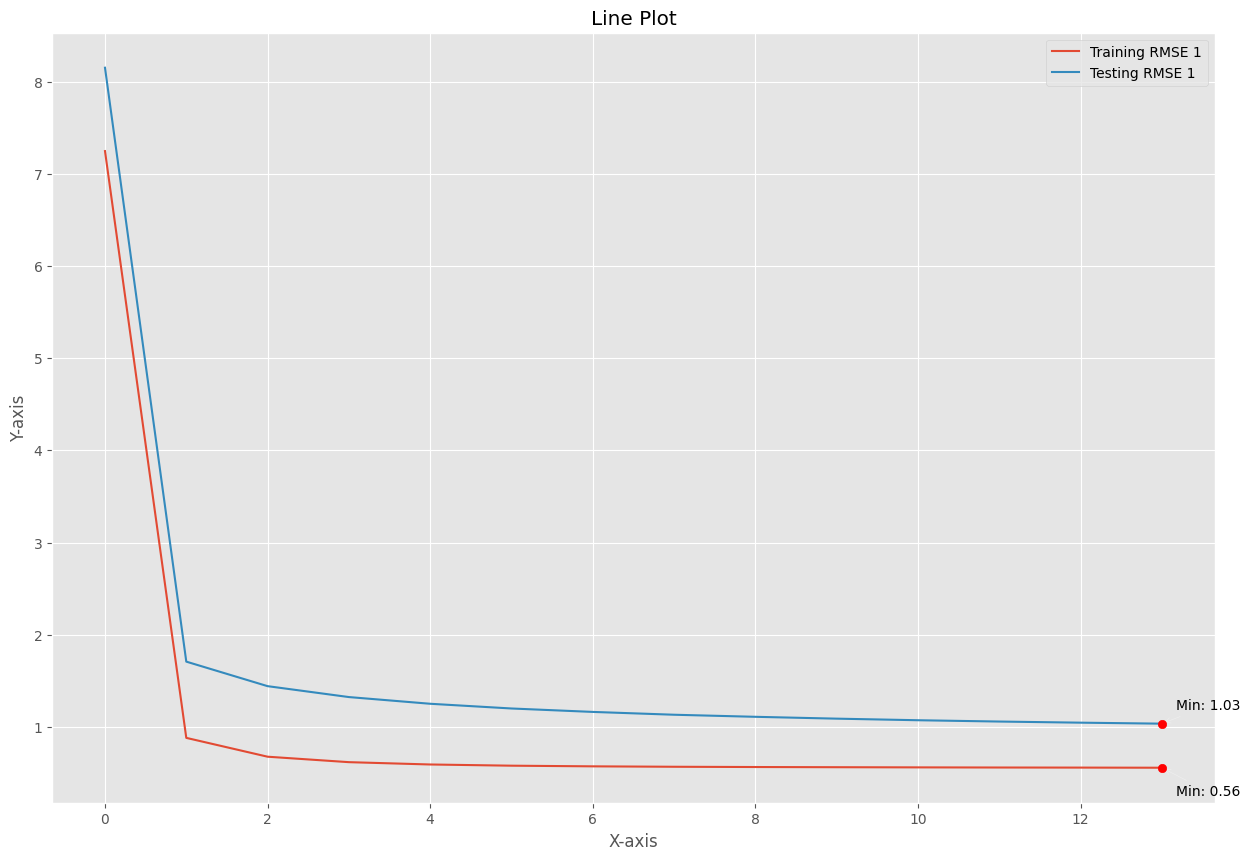

In [74]:
list1 = train_errors_result[0]
list2 = val_errors_result[0]

plt.figure(figsize=(15,10))
# Plotting the lists
plt.plot(list1, label='Training RMSE 1')
plt.plot(list2, label='Testing RMSE 1')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

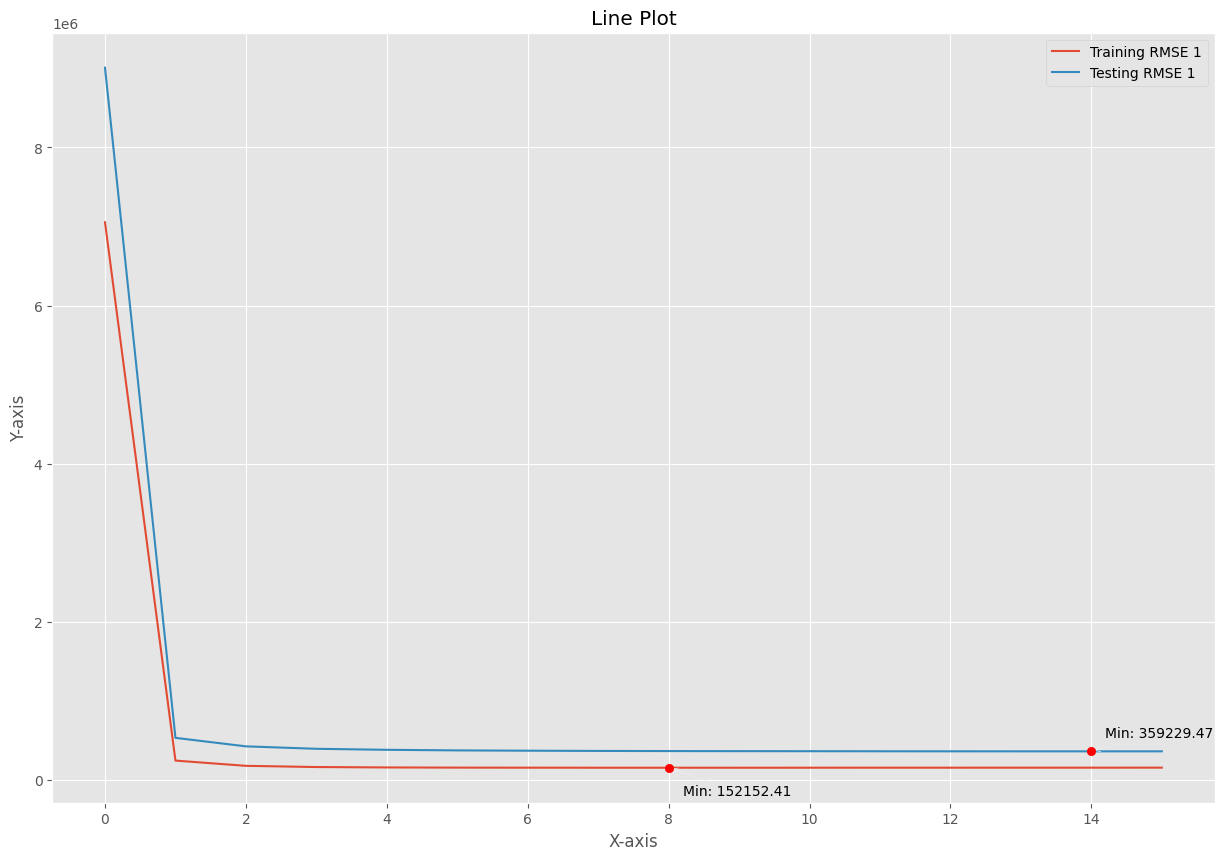

In [78]:
list1 = list(np.square(train_errors_result[1])*len(reindexed_train_set)/2)
list2 = list(np.square(val_errors_result[1])*len(reindexed_train_set)/2)

plt.figure(figsize=(15,10))
# Plotting the lists
plt.plot(list1, label='Training RMSE 1')
plt.plot(list2, label='Testing RMSE 1')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
import inspect
lines = inspect.getsource(LatentFactorsCollaborativeFiltering)
print(lines)

In [ ]:
from google.colab import files
import json

to_download = {
    "reg_list": reg_list.tolist(),
    "train_errors_result": train_errors_result,
    "val_errors_result": val_errors_result
}
x = json.dumps (to_download)
y = x.encode('utf-8')
with open('example.txt', 'w') as f:
  f.write(str(y))

files.download('example.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import numpy as np

def count_ratings_per_user(interactions):
    users, user_counts = np.unique(interactions[:, 0], return_counts=True)
    return users, user_counts

def count_ratings_per_item(interactions):
    items, item_counts = np.unique(interactions[:, 1], return_counts=True)
    return items, item_counts

# Your original interactions (user, item, rating)
interactions = np.array([[1, 2, 3], [4, 5, 6], [1, 5, 7], [3, 2, 8], [1, 2, 4], [4, 2, 6]])

# Count the number of ratings per user
users, user_counts = count_ratings_per_user(interactions)
print("Users and their ratings:")
for user, count in zip(users, user_counts):
    print(f"User {user} has {count} ratings.")

# Count the number of ratings per item
items, item_counts = count_ratings_per_item(interactions)
print("Items and their ratings:")
for item, count in zip(items, item_counts):
    print(f"Item {item} has {count} ratings.")


Users and their ratings:
User 1 has 3 ratings.
User 3 has 1 ratings.
User 4 has 2 ratings.
Items and their ratings:
Item 2 has 4 ratings.
Item 5 has 2 ratings.


In [9]:
X= np.array([[1,1,1], [2,2,2], [3,3,3]])
y = np.array([1,2,3])
X/(y[:, np.newaxis])

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [23]:
X[:,:-1] -= X[:,:-1]


In [24]:
X

array([[0, 0, 1],
       [0, 0, 2],
       [0, 0, 3]])